# Basic ML Models of the Kaggle House Price Dataset

In [1]:
import pandas as pd
print("pandas version: {}". format(pd.__version__))

# numpy: support for large, multi-dimensional arrays and matrices and high-level mathematical functions
import numpy as np
print("numpy version: {}". format(np.__version__))

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, Ridge, BayesianRidge, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import ShuffleSplit, train_test_split, cross_val_score, learning_curve
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
print("sklearn version: {}". format(sklearn.__version__))

import optuna
print("optuna version: {}". format(optuna.__version__))

import mlflow
from mlflow.utils.mlflow_tags import MLFLOW_PARENT_RUN_ID
from mlflow.tracking import MlflowClient
print("mlflow version: {}". format(mlflow.__version__))

import matplotlib.pyplot as plt
import seaborn as sns

import os
from datetime import datetime
from typing import Optional
import warnings
warnings.simplefilter('ignore')

import yaml
with open('ml_parameter.yaml') as file:
  config_data= yaml.safe_load(file)


from create_algorithm import create_algorithm
import pipeline_classes

pandas version: 1.5.2
numpy version: 1.23.5
sklearn version: 1.2.0


e:\programs\anaconda3\envs\mlflow_optuna\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


optuna version: 2.10.1
mlflow version: 2.1.1


In [2]:
VERSION = 0.5
SCRIPT = "houseprices_BasicModels_pipeline"

client = MlflowClient()
try:
    experiment = client.create_experiment(f"{SCRIPT}_{VERSION}")
except:
    experiment = client.get_experiment_by_name(f"{SCRIPT}_{VERSION}").experiment_id


# define cross validation
cv = ShuffleSplit(
    n_splits = 10,
    test_size = 0.2,
    random_state = 42
    )

In [3]:
def load_data():
    # load raw training and test dataset
    df_train = pd.read_csv("../01_RawData/train.csv")
    df_test = pd.read_csv("../01_RawData/test.csv")

    # drop features with more then 30% of missing values
    df_train = df_train.drop(["Id", "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis=1)
    df_test = df_test.drop(["Id", "PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis=1)

    # split the training and test dataset to the input features (x_train, x_test) and the survival class (y_train)
    y_train = df_train['SalePrice']
    x_train = df_train.drop(['SalePrice'], axis=1)
    x_test = df_test

    x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

    return x_train, y_train, x_validate, y_validate, x_test

x_train, y_train, x_validate, y_validate, x_test = load_data()

In [4]:
def create_model(self, trial):

    child_run = client.create_run(
        experiment_id=experiment,
        tags={
            MLFLOW_PARENT_RUN_ID: self.parent_run.info.run_id
        }
    )

    model = create_algorithm(self.model_type, trial, client, child_run, config_data)

    # create parameter for data preprocessing pipeline
    imputer_function_numeric=trial.suggest_categorical("preprocessing_imputer_function_numeric", ["SimpleImputer", "KNNImputer"])
    transform_skewed_features_flag=trial.suggest_categorical("preprocessing_transform_skewed_features_flag", [True, False])
    ohe_min_frequency=trial.suggest_float("preprocessing_ohe_min_frequency", 0, 0.2, log=False)
    ohe_max_categories=trial.suggest_int('preprocessing_ohe_max_categories', 5, 20)
    feature_selection_low_variance_flag=trial.suggest_float("preprocessing_feature_selection_low_variance_flag", 0.7, 0.99, log=False)
    correlation=trial.suggest_float("preprocessing_correlation", 0.7, 0.99, log=False)
    scaler = trial.suggest_categorical("columnprep__transformers_num", ["StandardScaler", "MinMaxScaler"])
    pca_n_components = trial.suggest_float('pca_n_components', 0, 1)

    # log all parameters of the data preprocessing with mlflow
    client.log_param(child_run.info.run_id, "preprocessing_imputer_function_numeric", imputer_function_numeric)
    client.log_param(child_run.info.run_id, "preprocessing_transform_skewed_features_flag", transform_skewed_features_flag)
    client.log_param(child_run.info.run_id, "preprocessing_ohe_min_frequency", ohe_min_frequency)
    client.log_param(child_run.info.run_id, "preprocessing_ohe_max_categories", ohe_max_categories)
    client.log_param(child_run.info.run_id, "preprocessing_feature_selection_low_variance_flag", feature_selection_low_variance_flag)
    client.log_param(child_run.info.run_id, "preprocessing_correlation", correlation)
    client.log_param(child_run.info.run_id, "preprocessing_scaler", scaler)  
    client.log_param(child_run.info.run_id, "pca_n_components", pca_n_components)


    pipeline = make_pipeline(
            pipeline_classes.ImputMissingValuesNumeric(imputer_function=imputer_function_numeric),
            pipeline_classes.ImputMissingValuesCategoric(),
            pipeline_classes.CreateNewFeatures(),
            pipeline_classes.ImputMissingValuesNumeric(imputer_function=imputer_function_numeric),
            pipeline_classes.SkewedFeatureTransformer(transform_skewed_features_flag=transform_skewed_features_flag),
            pipeline_classes.LabelEncoderTransformer(),
            pipeline_classes.OneHotEncoderTransformer(ohe_min_frequency=ohe_min_frequency, ohe_max_categories=ohe_max_categories),
            pipeline_classes.LowVarianceTransformer(variance_threshold=feature_selection_low_variance_flag),
            pipeline_classes.CorrelationTransformer(correlation_threshold=correlation),
            pipeline_classes.ScalerTransformer(columnprep__transformers_num=scaler),
            PCA(n_components=pca_n_components),
            model
    )

    return pipeline, child_run

In [5]:
def create_submission(best_model, x_test, parent_run, study):
    # check if folder exists
    if not os.path.exists(f'submissions/{SCRIPT}/{VERSION}'):
        os.makedirs(f'submissions/{SCRIPT}/{VERSION}')
    
    # predict the test values with the training classification model
    if study.best_params["log_transform_salePrice"] == True:
        y_pred = np.expm1(best_model.predict(x_test))
    else:
        y_pred = best_model.predict(x_test)
    
    df_submission = pd.read_csv("../01_RawData/sample_submission.csv")
    df_submission.iloc[:, 1] = y_pred
    
    df_submission.to_csv(f'submissions/{SCRIPT}/{VERSION}/{parent_run.info.run_id}.csv', index=False)

In [6]:
def evaluate_model(x_train, y_train, y_validate, y_validate_pred, pipeline, parent_run):

    def plot_learning_curve(pipeline, x_train, y_train, cv=cv, train_sizes=np.linspace(.1, 1.0, 50)):
        train_sizes, train_scores, test_scores = learning_curve(
            pipeline,
            x_train,
            y_train,
            cv=cv,
            n_jobs=-1,
            train_sizes=np.linspace(.1, 1.0, 8)
            )


        fig1, ax1 = plt.subplots()
        ax1.set_xlabel("Training examples")
        ax1.set_ylabel("Score")
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        ax1.grid()

        ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1,
                        color="r")
        ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color="g")
        ax1.plot(train_sizes, train_scores_mean, 'o-', color="r",
                label="Training score")
        ax1.plot(train_sizes, test_scores_mean, 'o-', color="g",
                label="Cross-validation score")

        ax1.legend(loc="best")
        ax1.set_title("Difference between training and CV: "\
            + str(round(test_scores_mean[7] / train_scores_mean[7] * 100, 2))\
            + "%")
        client.log_figure(parent_run.info.run_id, fig1, 'plot_learning_curve.png')
        plt.close()

    plot_learning_curve(pipeline, x_train, y_train)


    def plot_scatter(y_true, y_pred):
        fig2, ax2 = plt.subplots()
        ax2.scatter(y_pred, y_true.values)
        ax2.plot([min(y_pred), max(y_pred)], [min(y_pred), max(y_pred)], c="red")
        client.log_figure(parent_run.info.run_id, fig2, 'plot_regression.png')
        plt.close()

    plot_scatter(y_validate, y_validate_pred)

In [7]:
class Objective:
    
    def __init__(self, model_type, parent_run):
        self.best_model = None
        self._model = None
        self.model_type = model_type
        self.parent_run = parent_run

    
    def __call__(self, trial):
    
        pipeline, child_run = create_model(self, trial)
        self._model = pipeline

        log_transform_salePrice=trial.suggest_categorical("log_transform_salePrice", [True, False])
        client.log_param(child_run.info.run_id, "log_transform_salePrice", log_transform_salePrice)

        if log_transform_salePrice == True:
            rmse = np.sqrt(
                -cross_val_score(
                    TransformedTargetRegressor(
                        regressor=pipeline,
                        func=np.log,
                        inverse_func=np.exp
                        ),
                    x_train, y_train,
                    cv=cv,
                    scoring="neg_mean_squared_error",
                    n_jobs=-1
                    )
                ).mean()
        
        else:
            rmse = np.sqrt(
                -cross_val_score(
                    pipeline,
                    x_train, y_train,
                    cv=cv,
                    scoring="neg_mean_squared_error",
                    n_jobs=-1
                    )
                ).mean()

        client.log_metric(child_run.info.run_id, "cv_rmse", rmse)

        return rmse

    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model

In [8]:
# model_type='Lasso'
# model_type='Ridge'
# model_type='BayesianRidge'
# model_type='ElasticNet'
# model_type='GradientBoostingRegressor'
model_type='RandomForestRegressor'





parent_run = client.create_run(
    experiment_id=experiment, 
    tags={"script_name": SCRIPT, "script_version": VERSION}
    )

objective = Objective(model_type, parent_run)

study = optuna.create_study(direction="minimize")

study.optimize(
    objective,
    n_trials=config_data["N_TRAILS"],
    timeout=config_data["TIMEOUT"],
    n_jobs=-1,
    callbacks=[objective.callback]
    )

print("Best trial:")
print(study.best_value)
print(study.best_params)

print("Log CV Params")
client.log_metric(parent_run.info.run_id, "best_cv_score", round(study.best_value, 3))
# client.log_param(parent_run.info.run_id, "transformer_num", str(transformer_num))

client.log_param(parent_run.info.run_id, "cv_n_splits", cv.n_splits)
client.log_param(parent_run.info.run_id, "cv_train_size", cv.train_size)
client.log_param(parent_run.info.run_id, "cv_test_size", cv.test_size)
client.log_param(parent_run.info.run_id, "cv_random_state", cv.random_state)

for param in study.best_params:
    client.log_param(parent_run.info.run_id, param, study.best_params[param])

best_model = objective.best_model
client.log_param(parent_run.info.run_id, "algo", best_model.get_params()["steps"][-1][1].__class__.__name__)


# fit the pipeline to compute the validation results
print("Fit Best Model")
best_model.fit(x_train, y_train)

# predict the training outcome
print("Predict Best Model")
if study.best_params["log_transform_salePrice"] == True:
    y_validate_pred = np.expm1(best_model.predict(x_validate))
else:
    y_validate_pred = best_model.predict(x_validate)


# evaluate model
print("Evaluate Best Model")
evaluate_model(x_train, y_train, y_validate, y_validate_pred, best_model, parent_run)

# # create submission of best model
print("Create submission")
create_submission(best_model, x_test, parent_run, study)

mlflow.end_run()

[I 2023-02-18 16:34:27,898] A new study created in memory with name: no-name-90c86a8c-09c1-443e-ae8d-fddaf380d05f
[I 2023-02-18 16:35:16,926] Trial 0 finished with value: 72604.67374527066 and parameters: {'rfr_n_estimators': 418, 'rfr_min_samples_split': 0.4448309238958331, 'rfr_min_samples_leaf': 0.23505611903153373, 'rfr_max_depth': 4, 'rfr_max_features': 0.19562271364252226, 'rfr_max_leaf_nodes': 6, 'preprocessing_imputer_function_numeric': 'SimpleImputer', 'preprocessing_transform_skewed_features_flag': True, 'preprocessing_ohe_min_frequency': 0.052810998151184285, 'preprocessing_ohe_max_categories': 11, 'preprocessing_feature_selection_low_variance_flag': 0.8255675300441065, 'preprocessing_correlation': 0.8763541761244833, 'columnprep__transformers_num': 'StandardScaler', 'pca_n_components': 0.9321806192506334, 'log_transform_salePrice': False}. Best is trial 0 with value: 72604.67374527066.
[I 2023-02-18 16:35:26,156] Trial 2 finished with value: 80187.40861281288 and parameters

Best trial:
39395.796530591884
{'rfr_n_estimators': 3902, 'rfr_min_samples_split': 0.058908362725242844, 'rfr_min_samples_leaf': 0.05243126887558759, 'rfr_max_depth': 4, 'rfr_max_features': 0.9373722000494422, 'rfr_max_leaf_nodes': 10, 'preprocessing_imputer_function_numeric': 'SimpleImputer', 'preprocessing_transform_skewed_features_flag': False, 'preprocessing_ohe_min_frequency': 0.08888746332342105, 'preprocessing_ohe_max_categories': 11, 'preprocessing_feature_selection_low_variance_flag': 0.8534990727247982, 'preprocessing_correlation': 0.9038726420286336, 'columnprep__transformers_num': 'StandardScaler', 'pca_n_components': 0.5692185561696994, 'log_transform_salePrice': False}
Log CV Params
Fit Best Model
Predict Best Model
Evaluate Best Model
Create submission


In [2]:
def add_Kaggle_score(run_id, kaggle_score):
    # show if kaggle_score is already present
    if "kaggle_score" not in dict(dict(mlflow.get_run(run_id))["data"])["metrics"].keys():
        # if no kaggle_score is present, start run and write kaggle_score
        with mlflow.start_run(run_id=run_id):
            mlflow.log_metric("kaggle_score", kaggle_score)

In [3]:
# Version 0.5
add_Kaggle_score(run_id="82a292f0aad446139c4c91a06b2b4778", kaggle_score=0.2621) # Lasso
add_Kaggle_score(run_id="76548b96d89f422fa7ffbe4121882f83", kaggle_score=0.22585) # Ridge
add_Kaggle_score(run_id="20c743d91b884f93b7b96713ddc1043e", kaggle_score=1) # BayesianRidge -> inf
add_Kaggle_score(run_id="df553097911c4b7b885c03524fc77015", kaggle_score=0.17173) # ElasticNet
add_Kaggle_score(run_id="db2445f0589148e3b2bd203910c6a305", kaggle_score=1) # GradientBoostingRegressor -> inf
add_Kaggle_score(run_id="6ce64e8bb0c8455580d74c2ee069085d", kaggle_score=0.23861) # RandomForestRegressor

In [10]:
# add_Kaggle_score(run_id="eab21fd5a7f94493925c987347293087", kaggle_score=0.13808) # Ridge
# add_Kaggle_score(run_id="6f25f31ec3e146818f7279cb16cccaa6", kaggle_score=0.13304) # Ridge -> Position 1207
# add_Kaggle_score(run_id="3e6489469e424c9fbba08a232940e2c3", kaggle_score=0.26041) # Lasso
# add_Kaggle_score(run_id="3724cc35ec0b440d89b307e39c302261", kaggle_score=0.13313) # BayesianRidge
# add_Kaggle_score(run_id="90e0b665fb8c4367ae99691fb788eabc", kaggle_score=0.16332) # ElasticNet
# add_Kaggle_score(run_id="da0a81cd09fe4ddab4924118843fab6a", kaggle_score=0) # GradientBoostingRegressor -> inf
# add_Kaggle_score(run_id="467208197c064ef292167f0ad24f4484", kaggle_score=0.16307) # GradientBoostingRegressor
# add_Kaggle_score(run_id="a4941fe4f93846fd8cd559a94291532a", kaggle_score=0.27496) # RandomForestRegressor

In [9]:
list_runs = (
    "82a292f0aad446139c4c91a06b2b4778",
    "76548b96d89f422fa7ffbe4121882f83",
    "20c743d91b884f93b7b96713ddc1043e",
    "df553097911c4b7b885c03524fc77015",
    "db2445f0589148e3b2bd203910c6a305",
    "6ce64e8bb0c8455580d74c2ee069085d"
)

compare_scores = pd.DataFrame(columns=['algo','best_cv_score','kaggle_score'])
compare_scores = compare_scores.set_index("algo")

for run in list_runs:
    algo = dict(dict(mlflow.get_run(run))["data"])["params"]["algo"]
    best_cv_score = dict(dict(mlflow.get_run(run))["data"])["metrics"]["best_cv_score"]
    kaggle_score = dict(dict(mlflow.get_run(run))["data"])["metrics"]["kaggle_score"]

    compare_scores.loc[algo] = [best_cv_score, kaggle_score]

compare_scores

In [10]:
compare_scores

,best_cv_score,kaggle_score
algo,,
Lasso,34468.873,0.26210
Ridge,33513.204,0.22585
BayesianRidge,33211.310,1.00000
ElasticNet,34739.049,0.17173
GradientBoostingRegressor,29702.171,1.00000
RandomForestRegressor,39395.797,0.23861


<AxesSubplot:xlabel='best_cv_score', ylabel='kaggle_score'>

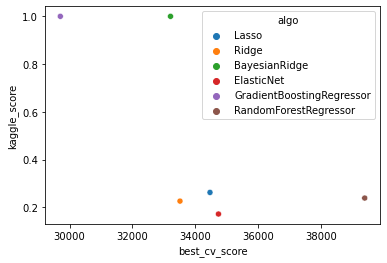

In [11]:
sns.scatterplot(data=compare_scores, x="best_cv_score", y="kaggle_score", hue=compare_scores.index)

<AxesSubplot:xlabel='best_cv_score', ylabel='kaggle_score'>

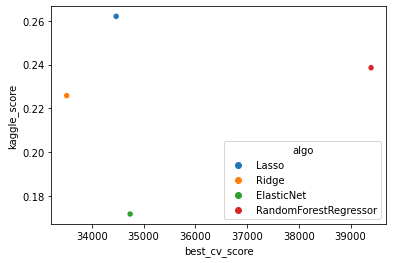

In [13]:
sns.scatterplot(data=compare_scores[compare_scores.kaggle_score != 1], x="best_cv_score", y="kaggle_score", hue=compare_scores[compare_scores.kaggle_score != 1].index)